<a href="https://colab.research.google.com/github/manjotmb20/Judicial-Decision-Prediction/blob/master/judicial_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
import os
import zipfile
import pandas as pd
import re
import nltk
nltk.download("punkt")
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [0]:
zipref=zipfile.ZipFile("data.zip")
zipref.extractall()
zipref.close()

In [0]:
violation="../content/data/violation/"
nonviolation="../content/data/non-violation/"

In [0]:
ventry=os.listdir(violation)
nventry=os.listdir(nonviolation)

In [0]:
df=pd.DataFrame()
df2=pd.DataFrame()
df["name"]=ventry
df2["name"]=nventry

In [0]:
df2["judging"]=""
df["judging"]=""
for i in range(len(df)):
    df["judging"][i]="violation"
for i in range(len(df2)):
    df2["judging"][i]="nonviolation"    
  



In [79]:
df=df.append(df2)
df

,name,judging
0,001-122889.txt,violation
1,001-93382.txt,violation
2,001-83480.txt,violation
3,001-110543.txt,violation
4,001-160863.txt,violation
...,...,...
52,001-155359.txt,nonviolation
53,001-139175.txt,nonviolation
54,001-142737.txt,nonviolation
55,001-60707.txt,nonviolation


In [0]:
def clean_text1(text):
  text=re.sub("\'()","",text)
  text=re.sub("[^a-zA-Z]"," ",text)
  text=' '.join(text.split())
  text=text.lower()
  return text  

In [0]:
violationlist=[]
for row in ventry:
  f=open(violation+row,"r",encoding = "ISO-8859-1").read()
  violationlist.append(clean_text1(f))



In [0]:
for row in nventry:
  f=open(nonviolation+row,"r",encoding = "ISO-8859-1").read()
  violationlist.append(clean_text1(f))

In [0]:
df["cases"]=violationlist

In [84]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  no_stopwords=[w for w in text.split() if not w in stop_words]
  return ' '.join(no_stopwords)
df["cases"]=df["cases"].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


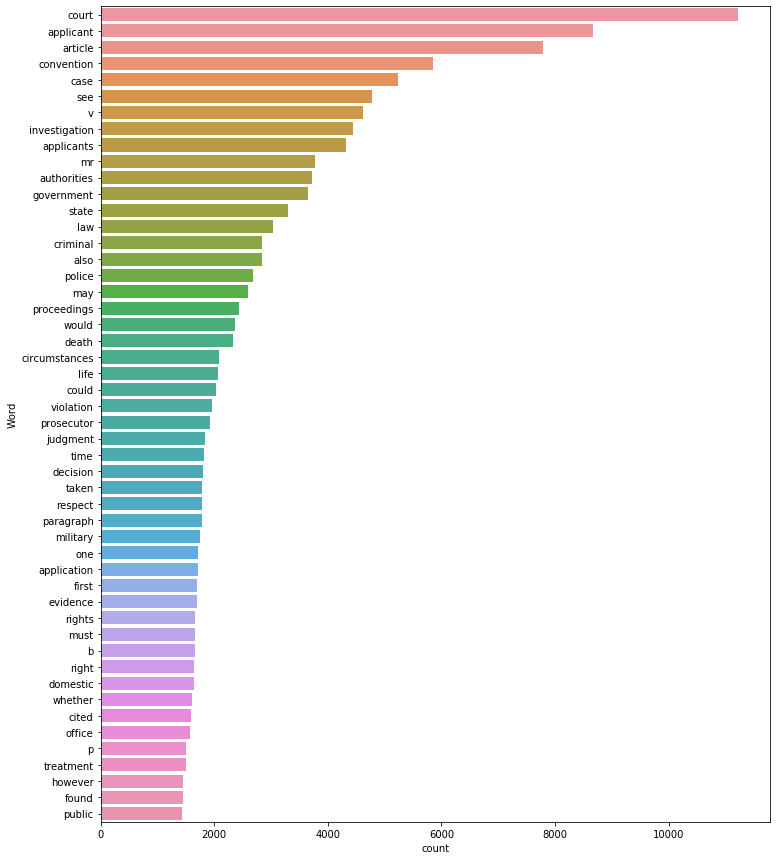

In [85]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  
  d = words_df.nlargest(columns="count", n = terms) 
  
 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  

freq_words(df["cases"], 50)

In [0]:
lc=LabelEncoder()
df["judging"]=lc.fit_transform(df["judging"])

In [87]:
df.tail()

,name,judging,cases
52,001-155359.txt,0,former second section case selahatt n dem rta ...
53,001-139175.txt,0,fifth section case v sweden application judgme...
54,001-142737.txt,0,former fifth section case paposhvili v belgium...
55,001-60707.txt,0,case mastromatteo v italy application judgment...
56,001-100903.txt,0,fifth section case pankov v bulgaria applicati...


In [0]:
tfidfvectorizer=TfidfVectorizer(max_df=0.8,max_features=2000)
x_train,x_val,y_train,y_val=train_test_split(df["cases"],df["judging"],test_size=0.2,random_state=9)
xtrain_tfidf=tfidfvectorizer.fit_transform(x_train)
xval_tfidf=tfidfvectorizer.transform(x_val)


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
clf3=xgb.XGBClassifier(learning_rate=0.1,n_estimators=200,max_depth=5,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.005,objective='binary:logistic',n_thread=4,scale_pos_weight=1)
clf=LogisticRegression()
clf2=GaussianNB()
clf.fit(xtrain_tfidf,y_train)
clf3.fit(xtrain_tfidf,y_train)
from sklearn.metrics import accuracy_score
y_pred=clf3.predict(xval_tfidf)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [90]:
print(accuracy_score(y_val,y_pred))

0.9130434782608695


In [91]:
lc.inverse_transform(y_pred)

array(['nonviolation', 'violation', 'nonviolation', 'nonviolation',
       'violation', 'violation', 'violation', 'violation', 'nonviolation',
       'nonviolation', 'nonviolation', 'violation', 'nonviolation',
       'nonviolation', 'violation', 'violation', 'violation', 'violation',
       'violation', 'violation', 'violation', 'violation', 'nonviolation'],
      dtype=object)

In [0]:
test=[]
t=open("test2.txt","r",encoding="ISO-8859-1").read()
test.append(clean_text1(t))
dftest=pd.DataFrame()
dftest["content"]=test
dftest["content"]=dftest["content"].apply(lambda x: remove_stopwords(x))

xtest_tfidf=tfidfvectorizer.transform(dftest["content"])


In [93]:
ytest=clf3.predict(xtest_tfidf)
print(lc.inverse_transform(ytest))

['nonviolation']


In [0]:
save_classifier=open("classifier.pickle","wb")
pickle.dump(clf3,save_classifier)
save_classifier.close()